# On normalizing flows


- density estimation (i.e., moon data) and sampling
- (variational) inference and reparameterization for MCMC (see orig flow paper)

- autoregressive flows (transformer and conditioner)
- coupling flows (realnvp)
- masked autoregressive flows
- ffored
- inverse autoregressive flows
-planar and radial
 => easy to compute jacobian! 

- cubic spline flows

- references:
    - the one blog
    - review from papa
    - orig papers
    - eric jang

## Theory

explain theory here. change of variables, etc.

explain that lower jacobian is good

explain how multiple jacobians compuite

explain how jacobian is computed

## Implementation

make more complex examples with TFP

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions
tfb = tfp.bijectors

sns.set_style("white")
sns.set_context("notebook")

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [279]:
def make_degrees(p, hidden_dims):
    m = [tf.constant(range(1, p + 1))]
    for dim in hidden_dims:                
        n_min = min(np.min(m[-1]), p - 1)
        degrees = (np.arange(dim) % max(1, p - 1) + min(1, p - 1))
        degrees = tf.constant(degrees, dtype="int32")
        m.append(degrees)
    return m

In [280]:
make_degrees(2, [4, 4])

[<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 1], dtype=int32)>]

In [281]:
def make_masks(degrees):
    masks = [None] * len(degrees)
    for i, (ind, outd) in enumerate(zip(degrees[:-1], degrees[1:])):
        masks[i] = tf.cast(ind[:, tf.newaxis] <= outd, dtype="float32")        
    masks[-1] = tf.cast(degrees[-1][:, np.newaxis] < degrees[0], dtype="float32")
    return masks

In [283]:
make_masks(make_degrees(2, [4, 4]))

[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[1., 1., 1., 1.],
        [0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
 array([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=float32)>]

In [489]:
def make_constraint(mask):    
    def _constraint(x):
        return mask * tf.identity(x)
    return _constraint

In [490]:
def make_init(mask):
    def _init(shape, dtype=None):
        return mask * tf.keras.initializers.GlorotUniform()(shape)
    return _init

In [491]:
def make_network(p, hidden_dims, params):
    masks = make_masks(make_degrees(p, hidden_dims))    
    masks[-1] = tf.tile(masks[-1][..., tf.newaxis], [1, 1, params])
    masks[-1] = tf.reshape(masks[-1], [masks[-1].shape[0], p * params])
    
    network =  tf.keras.Sequential([
        tf.keras.layers.InputLayer((p,))
    ])
    for dim, mask in zip(hidden_dims + [p * params], masks):
        layer = tf.keras.layers.Dense(
            dim,
            kernel_constraint=make_constraint(mask),
            kernel_initializer=make_init(mask),
            activation=tf.nn.leaky_relu)
        network.add(layer)    
    network.add(tf.keras.layers.Reshape([p, params]))
    
    return network

In [492]:
network = make_network(2, [5, 5], 2)

In [493]:
network(X)

<tf.Tensor: shape=(10000, 2, 2), dtype=float32, numpy=
array([[[ 0.        ,  0.        ],
        [ 0.00811941, -0.00262798]],

       [[ 0.        ,  0.        ],
        [ 0.11479491,  0.27078393]],

       [[ 0.        ,  0.        ],
        [ 0.01422059, -0.00460272]],

       ...,

       [[ 0.        ,  0.        ],
        [ 0.02674027, -0.00865492]],

       [[ 0.        ,  0.        ],
        [ 0.01912639, -0.00619057]],

       [[ 0.        ,  0.        ],
        [ 0.01442783, -0.0046698 ]]], dtype=float32)>

In [494]:
network.trainable_variables

[<tf.Variable 'dense_304/kernel:0' shape=(2, 5) dtype=float32, numpy=
 array([[-0.15562803, -0.45559144,  0.2228818 , -0.01438761, -0.8006845 ],
        [-0.        , -0.        , -0.        ,  0.        , -0.        ]],
       dtype=float32)>,
 <tf.Variable 'dense_304/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_305/kernel:0' shape=(5, 5) dtype=float32, numpy=
 array([[ 0.67071736, -0.28469315, -0.13938463, -0.714302  , -0.69200194],
        [-0.19252783,  0.3556397 ,  0.30783665,  0.13872033,  0.23336697],
        [-0.16491824,  0.34295988,  0.72527814, -0.6238706 , -0.28369144],
        [-0.27111614,  0.66546845,  0.72590864,  0.25627983, -0.4149166 ],
        [ 0.2680328 ,  0.00570953,  0.6022788 ,  0.409451  , -0.6352544 ]],
       dtype=float32)>,
 <tf.Variable 'dense_305/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_306/kernel:0' shape=(5, 4) dtype=float32, nu

In [501]:
class MAF(tfb.Bijector):
    def __init__(self, shift_and_log_scale_fn, name="maf"):
        super(MAF, self).__init__(forward_min_event_ndims=1, name=name)
        self._shift_and_log_scale_fn = shift_and_log_scale_fn
        
    def _shift_and_log_scale(self, y):
        params = self._shift_and_log_scale_fn(y)          
        shift, log_scale = tf.unstack(params, num=2, axis=-1)
        return shift, log_scale
        
    def _forward(self, x):
        y = tf.zeros_like(x, dtype=tf.float32)
        for i in range(x.shape[-1]):            
            shift, log_scale = self._shift_and_log_scale(y)            
            y = x * tf.math.exp(log_scale) + shift
        return y

    def _inverse(self, y):
        shift, log_scale = self._shift_and_log_scale(y)
        return (y - shift) * tf.math.exp(-log_scale)

    def _inverse_log_det_jacobian(self, y):
        _, log_scale = self._shift_and_log_scale(y)
        return -tf.reduce_sum(log_scale, axis=self.forward_min_event_ndims)
    

In [502]:
maf = MAF(make_network(2, [5, 5], 2))

In [504]:
maf.forward(tf.cast(X[:2, :], tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.26205978,  0.6935078 ],
       [-0.73196775,  1.5593543 ]], dtype=float32)>

## Density estimation

In [473]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

n = 10000
X, _ = datasets.make_moons(n_samples=n, noise=.05)
X = StandardScaler().fit_transform(X)

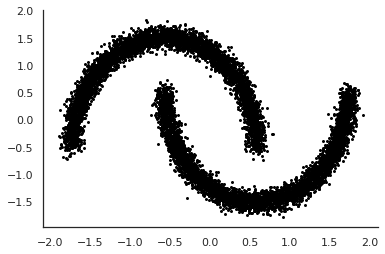

In [484]:
ax = sns.scatterplot(X[:, 0], X[:, 1], color="black", marker='.', linewidth=0);
sns.despine();

In [727]:
hidden_dim = [512, 512]  
layers = 2
bijectors = []
for i in range(0, layers):
    made = make_network(2, hidden_dim, 2)
    bijectors.append(MAF(made))
    bijectors.append(tfb.Permute(permutation=[1, 0])) 
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

In [728]:
distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[2]
)

In [729]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

In [730]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob)

In [731]:
model.fit(x=X,
          y=np.zeros((X.shape[0], 0), dtype=np.float32),
          batch_size= X.shape[0],
          epochs=3000,
          steps_per_epoch=1,
          shuffle=True)

Epoch 1/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.8492
Epoch 2/3000
1/1 [==============================] - 0s 27ms/step - loss: 2.7623
Epoch 3/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.7306
Epoch 4/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.7363
Epoch 5/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.7068
Epoch 6/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.6836
Epoch 7/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.6770
Epoch 8/3000
1/1 [==============================] - 0s 24ms/step - loss: 2.6746
Epoch 9/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.6667
Epoch 10/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.6554
Epoch 11/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.6468
Epoch 12/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.6418
Epoch 13/3000
1/1 [==================

1/1 [==============================] - 0s 25ms/step - loss: 2.2640
Epoch 203/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.2285
Epoch 204/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.1909
Epoch 205/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.1484
Epoch 206/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.1550
Epoch 207/3000
1/1 [==============================] - 0s 24ms/step - loss: 2.1375
Epoch 208/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.1821
Epoch 209/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.1425
Epoch 210/3000
1/1 [==============================] - 0s 24ms/step - loss: 2.1134
Epoch 211/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.1191
Epoch 212/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.1336
Epoch 213/3000
1/1 [==============================] - 0s 24ms/step - loss: 2.1316
Epoch 214/3000
1/1 [===========

1/1 [==============================] - 0s 24ms/step - loss: 2.5538
Epoch 303/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.5407
Epoch 304/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.5348
Epoch 305/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.5299
Epoch 306/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.5202
Epoch 307/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.5075
Epoch 308/3000
1/1 [==============================] - 0s 23ms/step - loss: 2.4997
Epoch 309/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.4949
Epoch 310/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.4902
Epoch 311/3000
1/1 [==============================] - 0s 23ms/step - loss: 2.4844
Epoch 312/3000
1/1 [==============================] - 0s 23ms/step - loss: 2.4792
Epoch 313/3000
1/1 [==============================] - 0s 24ms/step - loss: 2.4780
Epoch 314/3000
1/1 [===========

1/1 [==============================] - 0s 26ms/step - loss: 2.2775
Epoch 403/3000
1/1 [==============================] - 0s 23ms/step - loss: 2.2731
Epoch 404/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.2681
Epoch 405/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.2636
Epoch 406/3000
1/1 [==============================] - 0s 23ms/step - loss: 2.2589
Epoch 407/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.2540
Epoch 408/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.2494
Epoch 409/3000
1/1 [==============================] - 0s 23ms/step - loss: 2.2444
Epoch 410/3000
1/1 [==============================] - 0s 26ms/step - loss: 2.2396
Epoch 411/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.2348
Epoch 412/3000
1/1 [==============================] - 0s 24ms/step - loss: 2.2298
Epoch 413/3000
1/1 [==============================] - 0s 25ms/step - loss: 2.2249
Epoch 414/3000
1/1 [===========

1/1 [==============================] - 0s 24ms/step - loss: 1.8522
Epoch 503/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.8460
Epoch 504/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.8377
Epoch 505/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.8310
Epoch 506/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.8329
Epoch 507/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.8403
Epoch 508/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.8436
Epoch 509/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.8428
Epoch 510/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.8324
Epoch 511/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.8245
Epoch 512/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.8261
Epoch 513/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.8326
Epoch 514/3000
1/1 [===========

1/1 [==============================] - 0s 25ms/step - loss: 1.7392
Epoch 603/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.7334
Epoch 604/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.7243
Epoch 605/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.7222
Epoch 606/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.7247
Epoch 607/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.7314
Epoch 608/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.7385
Epoch 609/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.7383
Epoch 610/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.7293
Epoch 611/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.7170
Epoch 612/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.7130
Epoch 613/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.7188
Epoch 614/3000
1/1 [===========

1/1 [==============================] - 0s 26ms/step - loss: 1.6408
Epoch 703/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.6281
Epoch 704/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.6361
Epoch 705/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.6480
Epoch 706/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.6547
Epoch 707/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.6385
Epoch 708/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.6309
Epoch 709/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.6356
Epoch 710/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.6286
Epoch 711/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.6211
Epoch 712/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.6301
Epoch 713/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.6404
Epoch 714/3000
1/1 [===========

1/1 [==============================] - 0s 26ms/step - loss: 1.5713
Epoch 803/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.5600
Epoch 804/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.5587
Epoch 805/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5599
Epoch 806/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5611
Epoch 807/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.5543
Epoch 808/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.5460
Epoch 809/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.5486
Epoch 810/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.5528
Epoch 811/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5506
Epoch 812/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.5461
Epoch 813/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.5456
Epoch 814/3000
1/1 [===========

1/1 [==============================] - 0s 25ms/step - loss: 1.5197
Epoch 903/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.5568
Epoch 904/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.5446
Epoch 905/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5115
Epoch 906/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5409
Epoch 907/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.5336
Epoch 908/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5252
Epoch 909/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.5235
Epoch 910/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5062
Epoch 911/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.5107
Epoch 912/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5379
Epoch 913/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5610
Epoch 914/3000
1/1 [===========

1/1 [==============================] - 0s 25ms/step - loss: 1.5295
Epoch 1003/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4835
Epoch 1004/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.5017
Epoch 1005/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5210
Epoch 1006/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4973
Epoch 1007/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.5092
Epoch 1008/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.5230
Epoch 1009/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4928
Epoch 1010/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4707
Epoch 1011/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4986
Epoch 1012/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4936
Epoch 1013/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4674
Epoch 1014/3000
1/1 

1/1 [==============================] - 0s 23ms/step - loss: 1.4374
Epoch 1199/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4274
Epoch 1200/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4328
Epoch 1201/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4416
Epoch 1202/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4436
Epoch 1203/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4421
Epoch 1204/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4400
Epoch 1205/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4346
Epoch 1206/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4293
Epoch 1207/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4230
Epoch 1208/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4234
Epoch 1209/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4304
Epoch 1210/3000
1/1 

1/1 [==============================] - 0s 25ms/step - loss: 1.4169
Epoch 1395/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4079
Epoch 1396/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4100
Epoch 1397/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.4176
Epoch 1398/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4289
Epoch 1399/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4314
Epoch 1400/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.4338
Epoch 1401/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4255
Epoch 1402/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4134
Epoch 1403/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.4030
Epoch 1404/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4042
Epoch 1405/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4097
Epoch 1406/3000
1/1 

1/1 [==============================] - 0s 24ms/step - loss: 1.4094
Epoch 1591/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4362
Epoch 1592/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4427
Epoch 1593/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4142
Epoch 1594/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4091
Epoch 1595/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4229
Epoch 1596/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4191
Epoch 1597/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3995
Epoch 1598/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3957
Epoch 1599/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4131
Epoch 1600/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4261
Epoch 1601/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4368
Epoch 1602/3000
1/1 

1/1 [==============================] - 0s 25ms/step - loss: 1.4789
Epoch 1787/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4520
Epoch 1788/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.4022
Epoch 1789/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3936
Epoch 1790/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4261
Epoch 1791/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4467
Epoch 1792/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4231
Epoch 1793/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4049
Epoch 1794/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.4098
Epoch 1795/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4047
Epoch 1796/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3938
Epoch 1797/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3972
Epoch 1798/3000
1/1 

1/1 [==============================] - 0s 25ms/step - loss: 1.4073
Epoch 1983/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3976
Epoch 1984/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3848
Epoch 1985/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3837
Epoch 1986/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3829
Epoch 1987/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3908
Epoch 1988/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3898
Epoch 1989/3000
1/1 [==============================] - 0s 27ms/step - loss: 1.3877
Epoch 1990/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3863
Epoch 1991/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3840
Epoch 1992/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3905
Epoch 1993/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3971
Epoch 1994/3000
1/1 

1/1 [==============================] - 0s 25ms/step - loss: 1.3998
Epoch 2179/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4018
Epoch 2180/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3888
Epoch 2181/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3823
Epoch 2182/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3869
Epoch 2183/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3973
Epoch 2184/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4005
Epoch 2185/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3996
Epoch 2186/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4033
Epoch 2187/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4111
Epoch 2188/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4215
Epoch 2189/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.4231
Epoch 2190/3000
1/1 

1/1 [==============================] - 0s 24ms/step - loss: 1.3892
Epoch 2375/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3957
Epoch 2376/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3980
Epoch 2377/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3972
Epoch 2378/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3882
Epoch 2379/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3796
Epoch 2380/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3765
Epoch 2381/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3786
Epoch 2382/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3813
Epoch 2383/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3834
Epoch 2384/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3841
Epoch 2385/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3825
Epoch 2386/3000
1/1 

1/1 [==============================] - 0s 25ms/step - loss: 1.3972
Epoch 2571/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4074
Epoch 2572/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4069
Epoch 2573/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4018
Epoch 2574/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4157
Epoch 2575/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.4317
Epoch 2576/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.4039
Epoch 2577/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3778
Epoch 2578/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.3907
Epoch 2579/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4035
Epoch 2580/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3982
Epoch 2581/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3864
Epoch 2582/3000
1/1 

1/1 [==============================] - 0s 26ms/step - loss: 1.3757
Epoch 2767/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3831
Epoch 2768/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3845
Epoch 2769/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3833
Epoch 2770/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3824
Epoch 2771/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3861
Epoch 2772/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3896
Epoch 2773/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3842
Epoch 2774/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3735
Epoch 2775/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.3687
Epoch 2776/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.3765
Epoch 2777/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3815
Epoch 2778/3000
1/1 

1/1 [==============================] - 0s 26ms/step - loss: 1.3958
Epoch 2963/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3863
Epoch 2964/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3928
Epoch 2965/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3845
Epoch 2966/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3699
Epoch 2967/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.3686
Epoch 2968/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3841
Epoch 2969/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4044
Epoch 2970/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4185
Epoch 2971/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4365
Epoch 2972/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.4291
Epoch 2973/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.4176
Epoch 2974/3000
1/1 

In [734]:
samples = distribution.sample(1000)

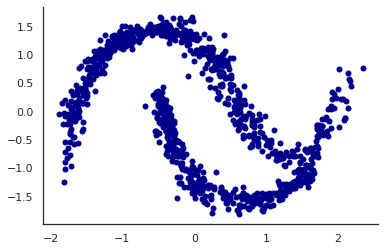

In [736]:
samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

## Variational inference

In [184]:
Y = tfd.Normal(2.0, 0.05).sample(10000)

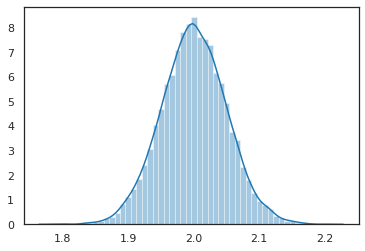

In [185]:
sns.distplot(Y)

In [186]:
Root = tfd.JointDistributionCoroutine.Root

def make_joint_distribution_coroutine():
    def model():        
        b1 = yield Root(tfd.Normal(loc=0.0, scale=1.0, name="b1"))
        sigma = yield Root(tfd.HalfNormal(scale=5, name="sigma"))
        yield tfd.Normal(loc=b0 + X * b1, scale=1.0, name='likelihood')
        yield tfd.Normal(loc=b0, scale=1.0, name='likelihood')
    return tfd.JointDistributionCoroutine(model)

model = make_joint_distribution_coroutine()

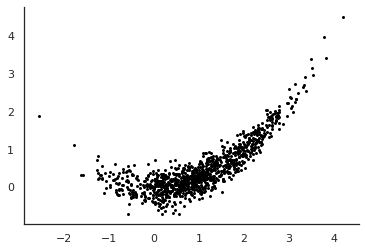

In [347]:
sns.scatterplot(b0, b1, color="black", marker='.', linewidth=0);
sns.despine();

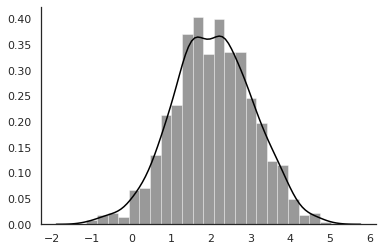

In [326]:
sns.distplot(Y,  color="black");
sns.despine();

In [17]:
def target_log_prob_fn(*args):    
    return tf.reduce_sum(model.log_prob(*args, likelihood=Y))

In [286]:
variational_posterior = tfd.JointDistributionSequential([  
  tfd.Normal(tf.Variable(0.0, name="q_b0_loc"), 
             tfp.util.TransformedVariable(1.0, tfb.Softplus(), name='q_b0_scale')),
  tfd.Normal(tf.Variable(0.0, name="q_b1_loc"),
             tfp.util.TransformedVariable(1.0, tfb.Softplus(), name='q_b1_scale')),
  tfd.HalfNormal(tfp.util.TransformedVariable(0.0, tfb.Softplus(), name='q_sigma'))
])

In [23]:
q = tfd.Normal(tf.Variable(0.0), 1.0)

In [37]:
optimizer = tf.optimizers.Adam(learning_rate=1e-3)
fit = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn, 
    q,
    optimizer=optimizer,
    num_steps=5000, 
     sample_size=1,
    seed=23)

In [39]:
print(q.mean(), q.stddev())

tf.Tensor(0.99794674, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


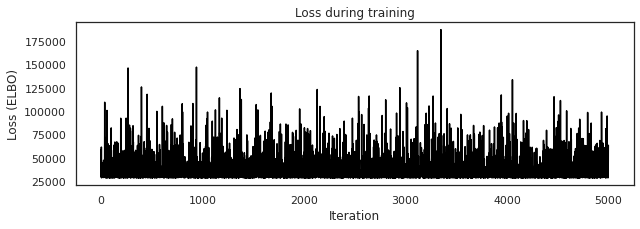

In [40]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(fit, 'k-')
ax.set(xlabel="Iteration", ylabel="Loss (ELBO)", title="Loss during training");


In [297]:
(q_b0, q_b1, q_sigma), _ = variational_posterior.sample_distributions()

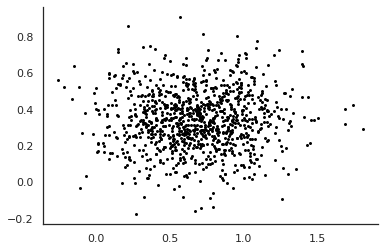

In [298]:
sns.scatterplot(q_b0.sample(1000), q_b1.sample(1000), color="black", marker='.', linewidth=0);
sns.despine();

In [ ]:
 # Easy Problem

In [188]:
X = tfd.Normal(0.0, 1.0).sample(100)
y = 2 * X + tfd.Normal(0.0, 1).sample(100)

In [189]:
def model_fn():
    mu = yield Root(tfd.Normal(loc=0.0, scale=1.0, name="mu"))
    sigma = yield Root(tfd.HalfNormal(scale=1, name="sigma"))
    yield tfd.Independent(tfd.Normal(X * mu, 1.0),
                          name="y", reinterpreted_batch_ndims=1)
model = tfd.JointDistributionCoroutine(model_fn)

In [190]:
def target_log_prob_fn(*args):
    return model.log_prob(*args, y=y)

In [192]:
variational_posterior = tfd.JointDistributionSequential([  
  tfd.Normal(tf.Variable(0.0), 
             tfp.util.TransformedVariable(1.0, tfb.Softplus()),
             name="q_mu"
            ),  
  tfd.HalfNormal(tfp.util.TransformedVariable(1.0, tfb.Softplus()), name="q_sigma")
])

In [193]:
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=variational_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),    
    num_steps=1000)

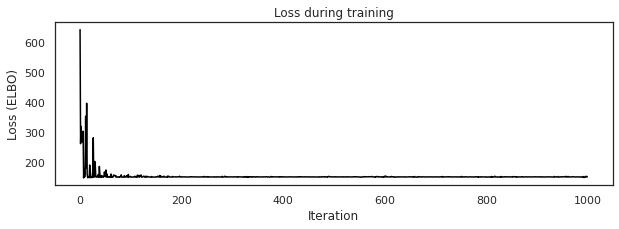

In [194]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(losses, 'k-')
ax.set(xlabel="Iteration", ylabel="Loss (ELBO)", title="Loss during training");

In [231]:
q_mu, _ = variational_posterior.sample(1000)

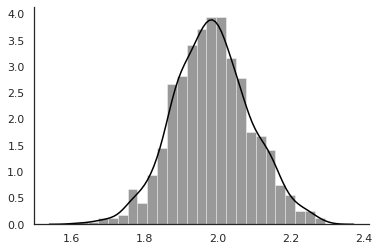

In [232]:
sns.distplot(q_mu, color="black");
sns.despine();

In [470]:
# A hard problem 

In [233]:
X = tfd.Normal(0.0, 1.0).sample(100)
y = 2 * X + tfd.Normal(0.0, 1).sample(100)

In [409]:
def model_fn():
    mu = yield Root(tfd.Horseshoe(scale=1, name="mu"))
    sigma = yield Root(tfd.HalfNormal(scale=1, name="sigma"))
    yield tfd.Independent(tfd.Normal(X * mu, 1.0),
                          name="y", reinterpreted_batch_ndims=1)
model = tfd.JointDistributionCoroutine(model_fn)

In [412]:
mu, _, _ = model.sample(100)

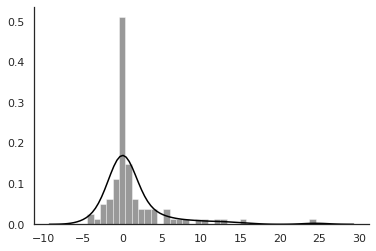

In [413]:
sns.distplot(mu, color="black");
sns.despine();

In [414]:
def target_log_prob_fn(*args):
    return model.log_prob(*args, y=y)

In [415]:
variational_posterior = tfd.JointDistributionSequential([  
  tfd.Normal(tf.Variable(0.0), 
             tfp.util.TransformedVariable(1.0, tfb.Softplus()),
             name="q_mu"
            ),  
  tfd.HalfNormal(tfp.util.TransformedVariable(1.0, tfb.Softplus()), name="q_sigma")
])

In [416]:
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=variational_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),    
    num_steps=1000)

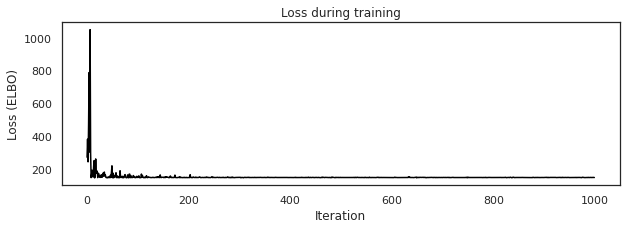

In [417]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(losses, 'k-')
ax.set(xlabel="Iteration", ylabel="Loss (ELBO)", title="Loss during training");

In [418]:
q_mu, _ = variational_posterior.sample(1000)

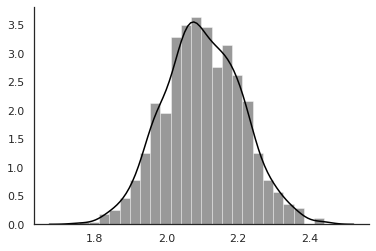

In [419]:
sns.distplot(q_mu, color="black");
sns.despine();

In [420]:
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name="leaky_relu"):
        super(LeakyReLU, self).__init__(
            event_ndims=1, validate_args=validate_args, name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):
        event_dims = self._event_dims_tensor(y)
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        log_abs_det_J_inv = tf.log(tf.abs(J_inv))
        return tf.reduce_sum(log_abs_det_J_inv, axis=event_dims)

In [481]:
layers = 10
bijectors = []
for i in range(0, layers):
    bijectors.append(LeakyReLU(alpha=tfp.util.TransformedVariable(1.0, tfb.Softplus())))    
    bijectors.append(tfb.Scale(tfp.util.TransformedVariable(1.0, tfb.Softplus())))    
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

In [482]:
q_mu = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=tf.Variable(0.0), 
                            scale=tfp.util.TransformedVariable(1.0, tfb.Softplus())),
    bijector=bijectors, name="q_mu"
)

In [483]:
variational_posterior = tfd.JointDistributionSequential([  
  q_mu, 
  tfd.HalfNormal(tfp.util.TransformedVariable(1.0, tfb.Softplus()), name="q_sigma")
])

In [484]:
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=variational_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),    
    num_steps=10000
)

In [485]:
q_mu_posterior, q_scale_posterior = variational_posterior.sample(10000)

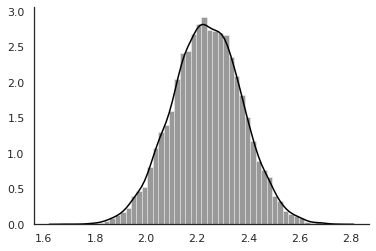

In [486]:
sns.distplot(q_mu_posterior, color="black");
sns.despine();

In [490]:
s, _ = variational_posterior.sample_distributions()